<a href="https://colab.research.google.com/github/kmayutrisna/IMDB/blob/main/IMDB_Glove%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary library
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM

In [ ]:
#Get the dataset from gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Display top of data
data =pd.read_csv("drive/My Drive/data/IMDB Dataset.csv")

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Text preprocessing
from nltk.corpus import stopwords
def preprocess_text(text):

    # Text cleaning
    text = re.sub('[^a-zA-Z]', ' ', text)

    #Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    #Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Lowercasing
    text = text.lower()

    # Lowercasing
    text = text.split()

    # Stopword removal
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if not word in stop_words]

    # Join the tokens back to a single string
    text = ' '.join(text)
    return text

In [ ]:
# Preprocess the text column
data['review'] = data['review'].apply(preprocess_text)

In [ ]:
# Preprocess the text data
texts = data['review'].values
labels = data['sentiment'].map({'positive': 1, 'negative': 0}).values

In [ ]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
# Tokenize the text data
num_words = 10000
max_sequence_length = 300

tokenizer = Tokenizer(num_words=num_words)  # You can adjust 'num_words' based on your vocabulary size
tokenizer.fit_on_texts(train_data)

# Convert text to sequences and pad them
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

  # You can adjust this based on your dataset
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

In [ ]:
# Load GloVe word embeddings
# Replace 'path_to_glove' with the path to your downloaded GloVe embeddings file
embedding_index = {}
with open('drive/My Drive/data/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients

# Create word-to-index mapping
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))  # Assuming you downloaded GloVe with 100-dimensional vectors
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Build CNN Model
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(Embedding(num_words, 100, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

#model = keras.Sequential([
#    Embedding(num_words, embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False),
 #   Conv1D(128, 5, activation='relu'),
  #  MaxPooling1D(5),
   # Flatten(),
    #Dense(1, activation='sigmoid')
#])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Train the Model
epochs = 5
batch_size = 128

history = model.fit(train_sequences, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 139s 549ms/step - loss: 0.6866 - accuracy: 0.5278 - val_loss: 0.6669 - val_accuracy: 0.5739
Epoch 2/5
250/250 [==============================] - 135s 539ms/step - loss: 0.6824 - accuracy: 0.5362 - val_loss: 0.6911 - val_accuracy: 0.5051
Epoch 3/5
250/250 [==============================] - 141s 564ms/step - loss: 0.6880 - accuracy: 0.5202 - val_loss: 0.6936 - val_accuracy: 0.5014
Epoch 4/5
250/250 [==============================] - 133s 534ms/step - loss: 0.6921 - accuracy: 0.5059 - val_loss: 0.6935 - val_accuracy: 0.5021
Epoch 5/5
250/250 [==============================] - 135s 541ms/step - loss: 0.6908 - accuracy: 0.5053 - val_loss: 0.6930 - val_accuracy: 0.5070


In [13]:
# Assuming you already have predictions and test_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

predictions = model.predict(test_sequences)
predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(test_labels, predictions)
print(f"MCC Score: {mcc * 100:.2f}%")

313/313 [==============================] - 17s 53ms/step
Accuracy: 50.31%
Precision: 79.66%
Recall: 1.87%
F1 Score: 3.65%
MCC Score: 6.40%


In [ ]:
# Calculate and print classification report
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(test_labels, predictions, target_names=['Negative', 'Positive'])
print("Classification Report:\n", report)

# Calculate and print confusion matrix
confusion = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:\n", confusion)

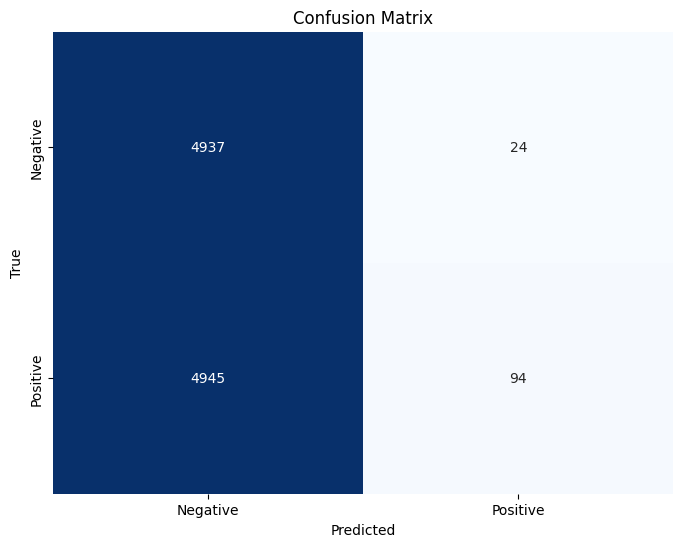

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
confusion = confusion_matrix(test_labels, predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

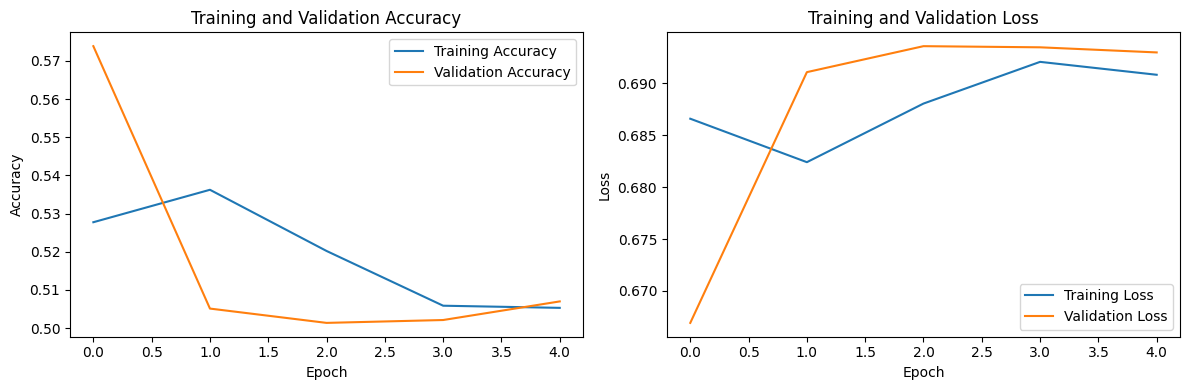

In [16]:
# Plot Training History (Accuracy and Loss)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()
